In [1]:
!nvidia-smi

Wed Jul 21 15:09:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Mounting the drive and copying the code from github to drive...anilaknb@gmail.com

from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [12]:
import pandas as pd
import re
import math
from functools import namedtuple
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

In [4]:
file_path = '/content/gdrive/MyDrive/EVA6_P1_S10/sample_coco.txt'

columns = '''classes
             img_h
             img_w
             bb_x
             bb_y
             bb_h
             bb_w             
             n_bb_h
             n_bb_w
             log_bb_h
             log_bb_w
             '''

In [5]:
def data_creation(file_path, columns):
    template_tup = namedtuple('template_tup', columns)
    collect_tup  = namedtuple('collect_tup', 'info')

    with open(file_path) as f:
       
        all_rows = f.readlines()
        for idx, row in enumerate(all_rows):
            '''
            Row format as below:
            id: 0, height: 330, width: 1093, bbox:[69, 464, 312, 175],
            '''
            if idx < len(all_rows) - 1: 
                row = re.sub('[a-z:]', '', row).replace('[', '').replace(']', '').replace('\n', '').split(',')[0:-1]
            else:            
                row = re.sub('[a-z:]', '', row).replace('[', '').replace(']', '').replace('\n', '').split(',')

            for i in range(len(row)):
                row[i]= int(row[i].strip())

            img_h, img_w, bb_h, bb_w = row[1], row[2], row[5], row[6]
            n_bb_h   = round(bb_h/img_h, 4)
            n_bb_w   = round(bb_w/img_w, 4)
            log_bb_h = round(math.log(n_bb_h), 4)
            log_bb_w = round(math.log(n_bb_w), 4)

            template = template_tup(*row, n_bb_h, n_bb_w, log_bb_h, log_bb_w)   
            if idx == 0:
                all_tup = collect_tup(template)
            else:
                all_tup += collect_tup(template)

            df = pd.DataFrame(data = all_tup)

    return df

In [6]:
df = data_creation(file_path, columns)

In [7]:
df[0:4]

,classes,img_h,img_w,bb_x,bb_y,bb_h,bb_w,n_bb_h,n_bb_w,log_bb_h,log_bb_w
0,0,330,1093,69,464,312,175,0.9455,0.1601,-0.0560,-1.8320
1,1,782,439,359,292,83,199,0.1061,0.4533,-2.2434,-0.7912
2,3,645,831,297,312,267,167,0.4140,0.2010,-0.8819,-1.6045
3,34,943,608,275,112,319,290,0.3383,0.4770,-1.0838,-0.7402


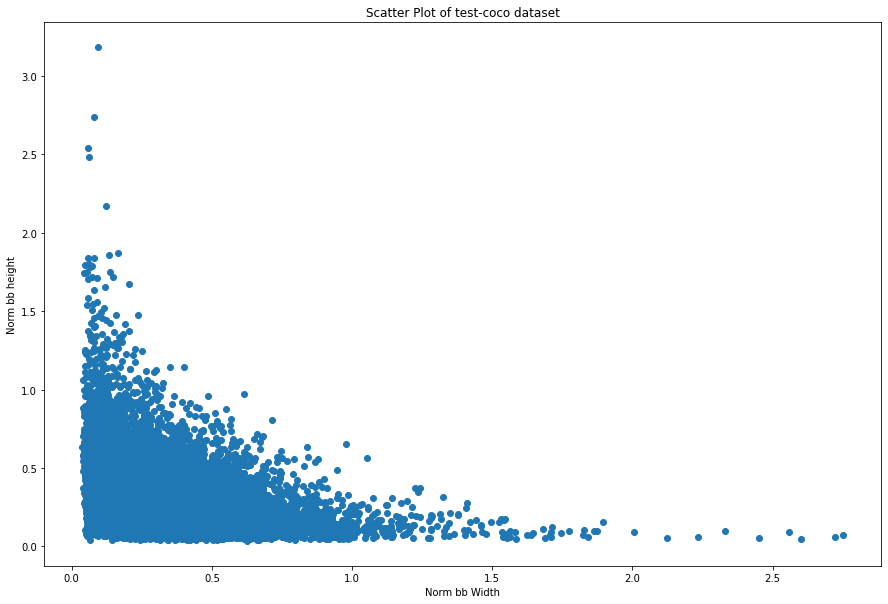

In [10]:
plt.figure(figsize = (15, 10))
plt.scatter(df['n_bb_w'], df['n_bb_h'])
plt.xlabel('Norm bb Width')
plt.ylabel('Norm bb height')
plt.title('Scatter Plot of test-coco dataset')
plt.show()

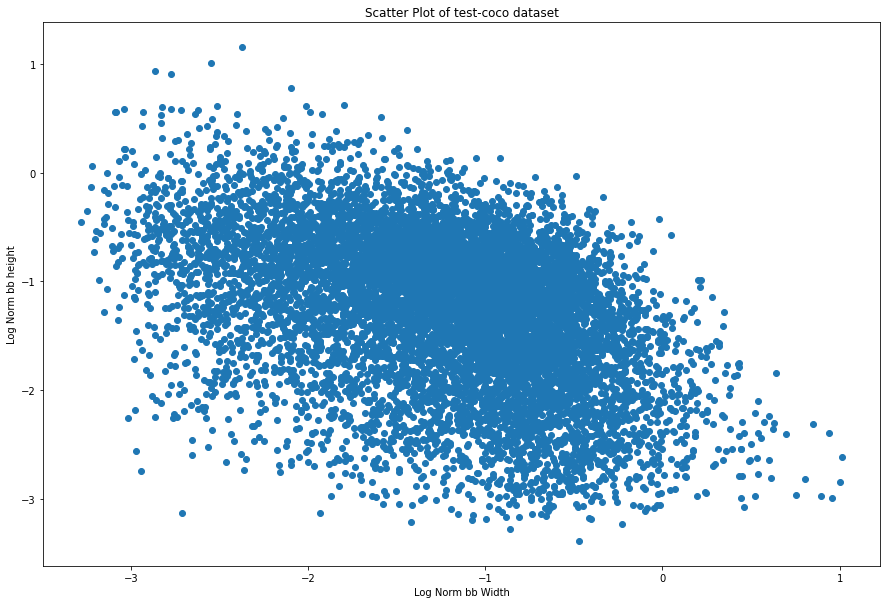

In [11]:
plt.figure(figsize = (15, 10))
plt.scatter(df['log_bb_w'], df['log_bb_h'])
plt.xlabel('Log Norm bb Width')
plt.ylabel('Log Norm bb height')
plt.title('Scatter Plot of test-coco dataset')
plt.show()

In [13]:
x = df[['log_bb_w', 'log_bb_h']].to_numpy()

In [14]:
wcss = []  # Within-Cluster Sum of Square -> sum of squared distance between each point and the centroid in a cluster.

'''
The KMeans algorithm clusters data by trying to separate samples in n groups of equal variance, minimizing a criterion known as
the inertia or within-cluster sum-of-squares.
Here we are trying out n=1 to 10 clusters to figure out which one is best
'''

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)

#### n=3 seems to be the best with steepest slope, while n = 4 is also not a bad choice where n is the number of clusters (number of template boxes to be used)


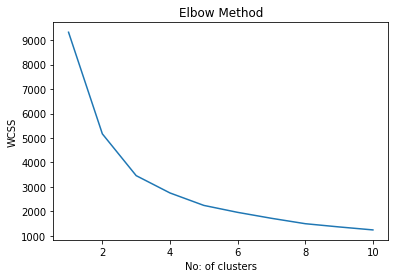

In [15]:
plt.plot(range(1,11), wcss)
plt.title('Elbow Method')
plt.xlabel('No: of clusters')
plt.ylabel('WCSS')
plt.show()